# Preparation

[View in Colaboratory](https://colab.research.google.com/github/stikbuf/Language_Modeling/blob/master/Keras_Character_Aware_Neural_Language_Models.ipynb)

## Configure the cloud environment


### Mount Google Drive

In [ ]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
# If you got a "Transport endpoint is not connected." error. Please run this line first to unmount the drive.
# See https://stackoverflow.com/questions/49588113/google-colab-script-throws-transport-endpoint-is-not-connected?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
!fusermount -u drive

# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive
a = !ls drive/
print('Files in Drive:', a)
assert a!=[], 'Drive should not be empty!'

In [ ]:
local_path='./drive/share_with_me/AI/Character-aware_LM/'
#local_path='./'
import sys
sys.path.append(local_path)
!ls './drive/share_with_me/AI/Character-aware_LM/'

In [ ]:
import tensorflow as tf
#assert tf.test.gpu_device_name() != '', "GPU not avaliable!"
tf.test.gpu_device_name()

## Load data (Penn Tree bank -- PTB)

In [1]:
local_path='./'

In [2]:
from __future__ import print_function
import os
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd

from reader import ptb_raw_data, ptb_producer # by Google

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
train_data, valid_data, test_data, word_to_id = ptb_raw_data(local_path + 'data') # tokens
id_to_word = dict((v, k) for k, v in word_to_id.items())
voc_size = len(id_to_word)
voc_size

10000

In [4]:
print('Train data size: {0}, Valid data size: {1}, Test data size: {2}\n'.
      format(len(train_data), len(valid_data), len(test_data)))
print('train/val/test_data is a list, some elements in train_data is', train_data[:10])

Train data size: 929589, Valid data size: 73760, Test data size: 82430

train/val/test_data is a list, some elements in train_data is [9970, 9971, 9972, 9974, 9975, 9976, 9980, 9981, 9982, 9983]


In [5]:
id_to_word[voc_size]='<SS>' # Add start word token '<SS>'
id_to_word[voc_size+1]='<EE>' # Add end word token '<EE>'
word_to_id = dict((v, k) for k, v in id_to_word.items())
voc_size = len(id_to_word)
voc_size

10002

In [6]:
word_id = pd.DataFrame.from_dict(word_to_id, orient='index').sort_values(by=0, ascending=True)
word_id.columns = ['id']
print(word_id.head())
print(word_id.tail())

       id
the     0
<unk>   1
<eos>   2
N       3
of      4
              id
ssangyong   9997
swapo       9998
wachter     9999
<SS>       10000
<EE>       10001


In [7]:
id_word = pd.DataFrame.from_dict(id_to_word, orient='index')
id_word.columns = ['word']
print(id_word.head())
print(id_word.tail())

    word
0    the
1  <unk>
2  <eos>
3      N
4     of
            word
9997   ssangyong
9998       swapo
9999     wachter
10000       <SS>
10001       <EE>


In [8]:
' '.join([id_to_word[id] for id in train_data[:50]])

'aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter <eos> pierre <unk> N years old will join the board as a nonexecutive director nov. N <eos> mr. <unk> is chairman of <unk> n.v. the dutch'

In [9]:
seq_len = 35

# RNN baseline

## data generator

In [10]:
import random

from tensorflow.python.keras.utils import to_categorical 

def gen_word_word(batch_size=128, dataset='train'):
    assert dataset in ['train', 'valid', 'test'], 'Dataset must be train or valid or test.'
    
    dic = {'train':train_data, 'valid':valid_data, 'test':test_data}
    data = dic[dataset]
    
    while True:
        rnd_idxs = list(range(len(data)-seq_len-1))
        random.shuffle(rnd_idxs)
        cnt = 0
        while cnt < len(rnd_idxs) - batch_size :
            X = np.array([[word_to_id['<SS>']] + data[i:i+seq_len] + [word_to_id['<EE>']]
                          for i in rnd_idxs[cnt:cnt+batch_size]])
            Y = X[:,1:]
            X = X[:,:-1]
            Y = to_categorical(Y)
            #print(X.shape)
            cnt += batch_size
            yield X, Y

## Keras model

In [11]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import GRU, Dense, Embedding, InputLayer, Dropout
from tensorflow.python.keras.optimizers import RMSprop

Add dropout between layers, see [Recurrent Neural Network Regularization](https://arxiv.org/abs/1409.2329)

In [12]:
model = Sequential()

embedding_size = 128


model.add(Embedding(input_dim=voc_size,
                    output_dim=embedding_size,
                    name='inputEmbedding'))
model.add(GRU(units=128, return_sequences=True))
model.add(Dropout(0.3)) 
model.add(GRU(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(voc_size, activation='softmax'))

In [13]:
# perplexity
def PPL(y_true, y_pred):
    return tf.exp(tf.reduce_mean(tf.keras.backend.categorical_crossentropy(y_true, y_pred)))

def ACC(y_true, y_pred):
    ACC = tf.equal(tf.argmax(y_true, axis = 2), 
                   tf.argmax(y_pred, axis = 2))
    ACC = tf.cast(ACC, tf.float32)

    return tf.reduce_mean(ACC)

In [14]:
optimizer = RMSprop(lr=1e-3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[ACC, PPL])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputEmbedding (Embedding)   (None, None, 128)         1280256   
_________________________________________________________________
gru_1 (GRU)                  (None, None, 128)         98688     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
gru_2 (GRU)                  (None, None, 64)          37056     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 10002)       650130    
Total params: 2,066,130
Trainable params: 2,066,130
Non-trainable params: 0
_________________________________________________________________


In [16]:
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint
import os
if not os.path.exists(local_path + 'model/'):
    os.mkdir(local_path + 'model/')

path_model = local_path + 'model/model.keras'    
tensorboard = TensorBoard(log_dir='log')
checkpoint = ModelCheckpoint(filepath=path_model, verbose=1,
                             monitor='val_PPL',mode='min' ,save_best_only='True')
# path_model = local_path + 'model/model.keras'
# model.save(path_model)

callback_lists=[tensorboard,checkpoint]

In [17]:
hist = model.fit_generator(generator=gen_word_word(), 
                           steps_per_epoch=50, epochs=125,
                           callbacks=callback_lists,
                           validation_data=gen_word_word(dataset='valid'),
                           validation_steps=30)

Epoch 1/100
49/50 [============================>.] - ETA: 0s - loss: 7.4025 - ACC: 0.0299 - PPL: 2238.6179
Epoch 00001: val_PPL improved from inf to 729.31307, saving model to ./model/model.keras
50/50 [==============================] - 55s 1s/step - loss: 7.3870 - ACC: 0.0305 - PPL: 2208.9620 - val_loss: 6.5916 - val_ACC: 0.0547 - val_PPL: 729.3131
Epoch 2/100
49/50 [============================>.] - ETA: 0s - loss: 6.5222 - ACC: 0.0527 - PPL: 680.8545
Epoch 00002: val_PPL improved from 729.31307 to 656.51662, saving model to ./model/model.keras
50/50 [==============================] - 51s 1s/step - loss: 6.5233 - ACC: 0.0528 - PPL: 681.6252 - val_loss: 6.4862 - val_ACC: 0.0551 - val_PPL: 656.5166
Epoch 3/100
49/50 [============================>.] - ETA: 0s - loss: 6.5067 - ACC: 0.0540 - PPL: 670.2737
Epoch 00003: val_PPL improved from 656.51662 to 649.24152, saving model to ./model/model.keras
50/50 [==============================] - 52s 1s/step - loss: 6.5061 - ACC: 0.0542 - PPL: 66

Epoch 48/100
49/50 [============================>.] - ETA: 0s - loss: 5.3376 - ACC: 0.1931 - PPL: 208.4806
Epoch 00048: val_PPL improved from 206.68730 to 203.56581, saving model to ./model/model.keras
50/50 [==============================] - 48s 957ms/step - loss: 5.3391 - ACC: 0.1930 - PPL: 208.8041 - val_loss: 5.3132 - val_ACC: 0.2039 - val_PPL: 203.5658
Epoch 49/100
49/50 [============================>.] - ETA: 0s - loss: 5.3089 - ACC: 0.1957 - PPL: 202.6321
Epoch 00049: val_PPL did not improve
50/50 [==============================] - 44s 879ms/step - loss: 5.3088 - ACC: 0.1956 - PPL: 202.5901 - val_loss: 5.3311 - val_ACC: 0.1997 - val_PPL: 207.3809
Epoch 50/100
49/50 [============================>.] - ETA: 0s - loss: 5.3226 - ACC: 0.1943 - PPL: 205.4597
Epoch 00050: val_PPL improved from 203.56581 to 197.65276, saving model to ./model/model.keras
50/50 [==============================] - 43s 852ms/step - loss: 5.3217 - ACC: 0.1945 - PPL: 205.2664 - val_loss: 5.2845 - val_ACC: 0.209

Epoch 74/100
49/50 [============================>.] - ETA: 0s - loss: 5.1701 - ACC: 0.2105 - PPL: 176.2739
Epoch 00074: val_PPL improved from 178.13573 to 176.60325, saving model to ./model/model.keras
50/50 [==============================] - 42s 849ms/step - loss: 5.1714 - ACC: 0.2102 - PPL: 176.5084 - val_loss: 5.1722 - val_ACC: 0.2181 - val_PPL: 176.6033
Epoch 75/100
49/50 [============================>.] - ETA: 0s - loss: 5.1834 - ACC: 0.2090 - PPL: 178.6776
Epoch 00075: val_PPL did not improve
50/50 [==============================] - 45s 896ms/step - loss: 5.1865 - ACC: 0.2085 - PPL: 179.2699 - val_loss: 5.2059 - val_ACC: 0.2142 - val_PPL: 182.8677
Epoch 76/100
49/50 [============================>.] - ETA: 0s - loss: 5.1875 - ACC: 0.2086 - PPL: 179.4254
Epoch 00076: val_PPL did not improve
50/50 [==============================] - 43s 856ms/step - loss: 5.1876 - ACC: 0.2086 - PPL: 179.4425 - val_loss: 5.1926 - val_ACC: 0.2175 - val_PPL: 180.5738
Epoch 77/100
49/50 [================

Epoch 100/100
49/50 [============================>.] - ETA: 0s - loss: 5.0905 - ACC: 0.2180 - PPL: 162.7309
Epoch 00100: val_PPL improved from 166.70837 to 166.46328, saving model to ./model/model.keras
50/50 [==============================] - 44s 886ms/step - loss: 5.0906 - ACC: 0.2180 - PPL: 162.7531 - val_loss: 5.1119 - val_ACC: 0.2246 - val_PPL: 166.4633


In [18]:
history = pd.DataFrame(hist.history)

Index(['ACC', 'PPL', 'loss', 'val_ACC', 'val_PPL', 'val_loss'], dtype='object')


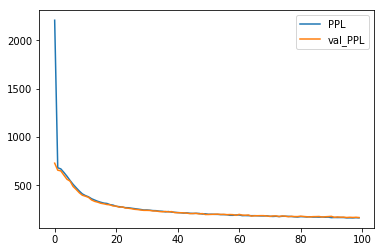

In [19]:
print(history.columns)
history.loc[:,['PPL','val_PPL']].tail(4600).plot()

In [20]:
# path_model = local_path + 'model/model.keras'
# model.save(path_model)

In [21]:
from tensorflow.python.keras.models import load_model

model_restore = load_model(path_model, custom_objects={'ACC':ACC,'PPL': PPL})

In [22]:
hist = model_restore.fit_generator(generator=gen_word_word(), 
                           steps_per_epoch=50, epochs=1,
                           callbacks=callback_lists,
                           validation_data=gen_word_word(dataset='valid'),
                           validation_steps=30)

Epoch 1/1
49/50 [============================>.] - ETA: 0s - loss: 5.0887 - ACC: 0.2185 - PPL: 162.5365
Epoch 00001: val_PPL did not improve
50/50 [==============================] - 48s 959ms/step - loss: 5.0894 - ACC: 0.2186 - PPL: 162.6333 - val_loss: 5.1154 - val_ACC: 0.2261 - val_PPL: 166.7546


Index(['ACC', 'PPL', 'loss', 'val_ACC', 'val_PPL', 'val_loss'], dtype='object')


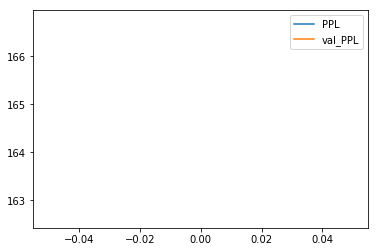

In [23]:
history = pd.DataFrame(hist.history)
print(history.columns)
history.loc[:,['PPL','val_PPL']].tail(4600).plot()

In [24]:
def predict_seq(model, preSeq=None, genLen=seq_len, power=1):
    """ Predict a sequence with length genLen.
        arg:
            model: Keras model used to predict.
            preSeq: list. The leading sequence.
            genLen: float or np.inf. If power is equal to np.inf, then an argmax will be used. 
            power: Probility power.
    """
    preSeq = [word_to_id['<SS>']] if preSeq == None else [word_to_id['<SS>']] + preSeq   
    pointer = len(preSeq) - 1
    
    for _ in range(genLen):
        inputSeq = np.array([preSeq])
        prob = model.predict(inputSeq)[0, pointer, :]
        if power==np.inf:
            pred = np.argmax(prob)
        else:
            prob = np.power(prob, power)
            prob = prob / np.sum(prob)
            pred = np.random.choice(range(voc_size), p=prob)
        preSeq.append(pred)
        pointer = pointer + 1

    return preSeq, ' '.join([id_to_word[id] for id in preSeq])

In [25]:
_, seq = predict_seq(model, power=1)
seq

'<SS> mr. cable says <eos> according to refinancing notably millions profitable directors increased N to N N off the end of september <eos> stock-index arbitrage trading has led as an fall in the <unk> <EE> <EE>'

# Character aware model

[Character-Aware Neural Language Models -- arxiv-1508.06615 -- AAAI 2016](https://arxiv.org/abs/1508.06615)

[Ref: Github/jarfo/kchar](https://github.com/jarfo/kchar)


![model](https://github.com/stikbuf/Language_Modeling/blob/master/Character%20aware.png?raw=true)


## Load data

### convert to text

Text(0.5,1,'word length distribution, max=19, min=1')

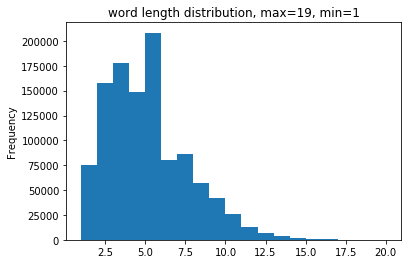

In [10]:
train_data_text = [id_to_word[idx] for idx in train_data]
valid_data_text = [id_to_word[idx] for idx in valid_data]
test_data_text = [id_to_word[idx] for idx in test_data]
total_data_text = train_data_text + valid_data_text + test_data_text

maxWordLen = max([len(word) for word in total_data_text])
maxWordLen += 2 # Start and End character

ds = pd.Series([len(word) for word in total_data_text])
ds.plot.hist(bins=range(1, maxWordLen))
plt.title('word length distribution, max={0}, min={1}'.
          format(ds.max(), ds.min()))

### merge chars

number of chars: 51 

['q', '8', 'E', '#', '3', 'r', 't', '0', 'n', 'a', 'h', 'p', '<', '6', '$', 'i', 'x', '4', 'N', 'k', '>', 'j', 's', 'm', '7', 'e', '/', '1', 'u', 'b', 'v', ' ', '-', "'", 'f', '.', 'o', 'd', 'w', '\\', 'y', '5', '&', 'g', 'S', '2', '*', 'z', 'c', '9', 'l'] 

{0: 'q', 1: '8', 2: 'E', 3: '#', 4: '3', 5: 'r', 6: 't', 7: '0', 8: 'n', 9: 'a', 10: 'h', 11: 'p', 12: '<', 13: '6', 14: '$', 15: 'i', 16: 'x', 17: '4', 18: 'N', 19: 'k', 20: '>', 21: 'j', 22: 's', 23: 'm', 24: '7', 25: 'e', 26: '/', 27: '1', 28: 'u', 29: 'b', 30: 'v', 31: ' ', 32: '-', 33: "'", 34: 'f', 35: '.', 36: 'o', 37: 'd', 38: 'w', 39: '\\', 40: 'y', 41: '5', 42: '&', 43: 'g', 44: 'S', 45: '2', 46: '*', 47: 'z', 48: 'c', 49: '9', 50: 'l'} 

{'q': 0, 'E': 2, '#': 3, '3': 4, 'r': 5, '0': 7, 'p': 11, 'x': 16, 'n': 8, 'a': 9, 'h': 10, '8': 1, '<': 12, '6': 13, 'k': 19, '$': 14, 'i': 15, '4': 17, 'N': 18, 'j': 21, '>': 20, '\\': 39, 's': 22, '/': 26, '7': 24, 'e': 25, '1': 27, 'v': 30, '5': 41, ' ': 31, '-'

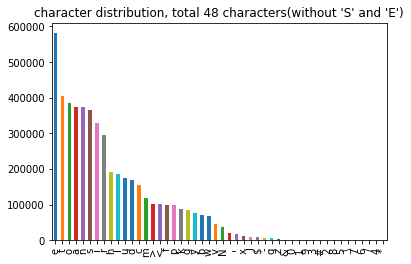

In [11]:
chars = []
for word in total_data_text:
    chars.extend(list(word))
    
ds = pd.Series(chars)
ds.value_counts().plot.bar()
plt.title('character distribution, total {0} characters(without \'S\' and \'E\')'.format(len(set(chars))))

chars = list(set(chars + ['S'] + ['E'] + [' ']))
# 'S' for word leading char, 'E' for word ending char, space for padding
id_to_chars = dict(enumerate(chars))
chars_to_id = dict((v, k) for k,v in id_to_chars.items())
num_chars = len(chars)

print('number of chars:', num_chars, '\n')
print(chars, '\n')
print(id_to_chars, '\n')
print(chars_to_id, '\n')

In [12]:
def word_to_charId(wordId):
    wordString = 'S' + id_to_word[wordId].center(maxWordLen - 2) + 'E'
    return [chars_to_id[char] for char in wordString]

def wordSeq_charSeq(bWordSeq):
    batch, seqLen = bWordSeq.shape
    bWordSeq = bWordSeq.ravel()
    charSeq = np.array([word_to_charId(wordId) for wordId in bWordSeq])
    return charSeq.reshape(batch, seqLen, -1)

word_to_charId(word_to_id['the']) # 

[44,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 6,
 10,
 25,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 2]

In [13]:
import random

from tensorflow.python.keras.utils import to_categorical 

def gen_char_word(batch_size=128, dataset='train'):
    assert dataset in ['train', 'valid', 'test'], 'Dataset must be train or valid or test.'
    
    dic = {'train':train_data, 'valid':valid_data, 'test':test_data}
    data = dic[dataset]
    
    while True:
        rnd_idxs = list(range(len(data)-seq_len-1))
        random.shuffle(rnd_idxs)
        cnt = 0
        while cnt < len(rnd_idxs) - batch_size :
            X = np.array([[word_to_id['<SS>']] + data[i:i+seq_len] + [word_to_id['<EE>']]
                          for i in rnd_idxs[cnt:cnt+batch_size]])
            Y = X[:,1:]
            X = X[:,:-1]
            Y = to_categorical(Y)
            X = wordSeq_charSeq(X) 
            #print(X.shape)
            cnt += batch_size
            yield X, Y

In [14]:
print(next(gen_char_word(batch_size=1, dataset='train'))[1][0][2].shape)

(10002,)


## option

In [25]:
class Option():
    def __init__(self):
        self.batch_size = 20
        self.seq_length = seq_len
        self.max_word_l = maxWordLen
        self.char_vocab_size = num_chars
        self.char_vec_size = 15
        self.feature_maps = [50,100,150,200,200,200,200]
        self.kernels = [1,2,3,4,5,6,7]
        self.highway_layers = 2
        self.num_lstm_layers = 2
        self.rnn_size = 650
        self.word_vocab_size = voc_size
        self.dropout = 0.5
        self.learing_rate = 1
        
opt = Option()

## CNN
![CNN part](https://github.com/stikbuf/Language_Modeling/blob/master/Character%20aware-CNN.png?raw=true)

In [26]:
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Concatenate, Reshape

def CNN(seq_length, length, feature_maps, kernels, x):

    concat_input = []
    for feature_map, kernel in zip(feature_maps, kernels):
        reduced_l = length - kernel + 1
        conv = Conv2D(feature_map, (1, kernel), activation='tanh', data_format="channels_last")(x)
        maxp = MaxPooling2D((1, reduced_l), data_format="channels_last")(conv)
        concat_input.append(maxp)

    x = Concatenate()(concat_input)
    x = Reshape((seq_length, sum(feature_maps)))(x)
    return x

## Highway Network  
[Srivastava et al.](https://arxiv.org/abs/1505.00387)

Input vector is $\textbf{y}$, then layer output $\textbf{z}$ is
$$\textbf{z = t} \odot g(\textbf{W}_H\textbf{y}+\textbf{b}_H) + \textbf{(1 - t)} \odot \textbf{y}$$
where 
$$\textbf{t} = \sigma(\textbf{W}_T\textbf{y}+\textbf{b}_T)$$

$\textbf{t}$ is called the
*transform gate*, and $(\textbf{1}−\textbf{t})$ is called the *carry gate*. 
Similar to the memory cells in LSTM networks, highway layers allow for training of deep networks by adaptively carrying some dimensions of the input directly to the output. By construction the dimensions of $\textbf{y}$ and $\textbf{z}$ have to match, and hence $\textbf{W}_T$ and $\textbf{W}_H$ are square matrices.  

A keras model is also a keras layer! So you can combine some keras layers to design your own layer. This is useful when combining with TimeDistributed wrapper. [See section 3 in this blog](https://keunwoochoi.wordpress.com/2016/11/18/for-beginners-writing-a-custom-keras-layer/)

In [27]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Dense, Activation, Multiply, Add, Lambda, Input
from tensorflow.python.keras.initializers import Constant
from tensorflow.python.keras.models import Model

def Highway(value, nLayers, activation='tanh', gateBias=-3):
    dim = K.int_shape(value)[-1]
    gateBiasInitalizer = Constant(gateBias)
    for i in range(nLayers):
        tGate = Dense(units=dim, bias_initializer=gateBiasInitalizer)(value)
        tGate = Activation('sigmoid')(tGate)
        cGate = Lambda(lambda x: 1.0-x)(tGate) # I do not specify output_shape
        transformed = Dense(units=dim, bias_initializer=gateBiasInitalizer)(value)
        transformed = Activation(activation)(value)
        transformedGate = Multiply()([tGate, transformed])
        identityGate = Multiply()([cGate, value])
        value = Add()([transformedGate, identityGate])
    return value

inputs = Input((sum(opt.feature_maps),))
HighwayLayer = Model(inputs=inputs, outputs=Highway(inputs, nLayers=opt.highway_layers))

In [34]:
from tensorflow.python.keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization, TimeDistributed
#from tensorflow.python.keras.optimizers import SGD

chars = Input(batch_shape=(opt.batch_size, opt.seq_length, opt.max_word_l), name='chars')
chars_embedding = Embedding(opt.char_vocab_size, opt.char_vec_size, name='chars_embedding')(chars)
cnn = CNN(opt.seq_length, opt.max_word_l, opt.feature_maps, opt.kernels, chars_embedding)
x = cnn
inputs = chars

x = BatchNormalization()(x)

x = TimeDistributed(HighwayLayer)(x)

for l in range(opt.num_lstm_layers):
    x = LSTM(opt.rnn_size, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, stateful=True)(x)

    if opt.dropout > 0:
        x = Dropout(opt.dropout)(x)
        
output = TimeDistributed(Dense(opt.word_vocab_size, activation='softmax'))(x)

model = Model(inputs=inputs, outputs=output)
model.summary()

#optimizer = SGD(lr=opt.learning_rate, clipnorm=opt.max_grad_norm, scale=float(opt.seq_length))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')      

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
chars (InputLayer)              (20, 35, 21)         0                                            
__________________________________________________________________________________________________
chars_embedding (Embedding)     (20, 35, 21, 15)     765         chars[0][0]                      
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (20, 35, 21, 50)     800         chars_embedding[0][0]            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (20, 35, 20, 100)    3100        chars_embedding[0][0]            
__________________________________________________________________________________________________
conv2d_59 